**Resume Classification and Analysis**


As students who are looking to apply for jobs in the industry, resumes are regularly a point of uncertainty. We often wonder if our resume is correct for the job we are applying for, do the skills mentioned align with requirements for the jobs, how do the contents of our resume compare to other candidates, what roles do our skills align with, etc.
 
As part of this project, we want to answer a few of these questions through analysis of datasets of thousands of resumes which have already been collected and tagged for us. 

More importantly, we will train Classification models to label a given resume into certain job roles and industries.


# Setup and Load Data

### Imports and Setup

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing import image
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from wordcloud import WordCloud,STOPWORDS
import string
from sklearn.feature_selection import chi2
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from io import StringIO
import nltk
nltk.download('averaged_perceptron_tagger')


from PIL import *
from collections import Counter
import re
import random

RANDOM_SEED = 72

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
# This cryptic line below is a "magic" command in jupyter to make the
# matplotlib plots high resolution
%config InlineBackend.figure_format = "retina"

# These commands adjust various font sizes in the matplotlib plots.
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 16

### Load Datasets

We will be working with two different datasets, both sourced from Kaggle. 
The datasets have labels at different grains and we will be comparing how well our classification models do on either of them.

In [ ]:
# Dataset1 with engineering related labels
df = pd.read_csv('UpdatedResumeDataSet.csv',encoding='utf-8')
df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [ ]:
# Dataset 2 with more general labels
df2 = pd.read_csv('Resume.csv', encoding='utf-8')
df2 = df2.drop(['ID','Resume_html'],axis=1)
df2.rename(columns = {'Resume_str':'Resume'}, inplace = True)
df2.head()

,Resume,Category
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,HR DIRECTOR Summary Over 2...,HR
3,HR SPECIALIST Summary Dedica...,HR
4,HR MANAGER Skill Highlights ...,HR


# Data Cleaning

### Cleanup Resume Text

In [ ]:
# English stop word dataset
nltk.download("punkt")
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = stopwords.words('english')

# Custom stop words list composed based on EDA done on the datasets in the Analysis section
custom_stop_words = ['state','city','skills','education','skill','company','experience','exprience','maharashtra','pune']

# Function to remove stop words from text strings
def remove_stop_words (text):
  result = []
  for token in gensim.utils.simple_preprocess(text):
    if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 1 and token not in stop_words and token not in custom_stop_words:
      result.append(token)

  return ' '.join(result)


# function to cleanup special characters and tokens from resume text
def preprocessResumeText(resumeText):
    # Fix encoding
    resumeText = resumeText.encode('ascii', 'ignore').decode('ascii')
    resumetext = str(resumeText)

    # cleanup unnecessary characters
    resumeText = re.sub('httpS+s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[\r\n]',r' ', resumeText) # Remove carriage returns and tab symbols
    resumeText = re.sub(r'\s+', ' ', resumeText)  # remove extra whitespace

    # Remove stop words
    resumeText = remove_stop_words(resumeText)

    return resumeText

# Cleanup 'Resume' column in both the datasets
df['cleaned_resume'] = df.Resume.apply(lambda x: preprocessResumeText(x))
df2['cleaned_resume'] = df2.Resume.apply(lambda x: preprocessResumeText(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Post Cleaning

In [ ]:
# First dataset after cleaning
df.head()

,Category,Resume,cleaned_resume
0,Data Science,Skills * Programming Languages: Python (pandas...,programming languages python pandas numpy scip...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,details uit rgpv data scientist data scientist...
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",areas deep learning control design programming...
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,python sap hana tableau sap hana sql sap hana ...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",details mca ymcaust faridabad haryana data sci...


In [ ]:
# Second dataset after cleaning
df2.head()

,Resume,Category,cleaned_resume
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR,hr administrator marketing associate hr admini...
1,"HR SPECIALIST, US HR OPERATIONS ...",HR,hr specialist hr operations summary versatile ...
2,HR DIRECTOR Summary Over 2...,HR,hr director summary years recruiting plus year...
3,HR SPECIALIST Summary Dedica...,HR,hr specialist summary dedicated driven dynamic...
4,HR MANAGER Skill Highlights ...,HR,hr manager highlights hr hr department startup...


# Data Analysis and Visualization

## Data Distribution

First we will see distribution of classes in both the datasets.

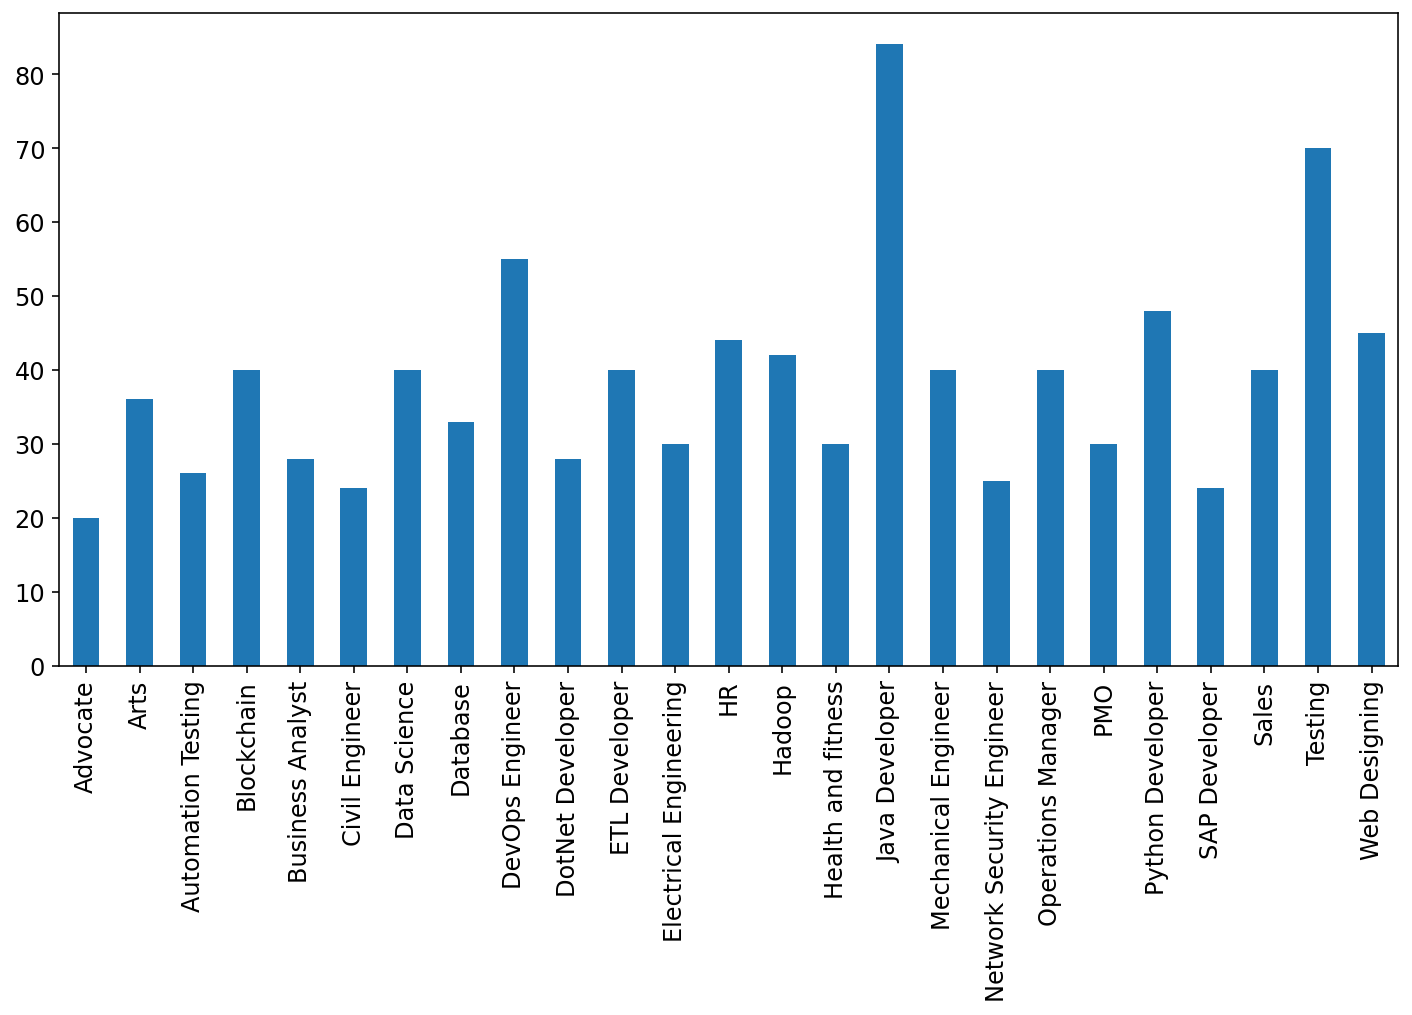

In [ ]:
# Class distribution in dataset 1
df['Category'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6))
plt.show()

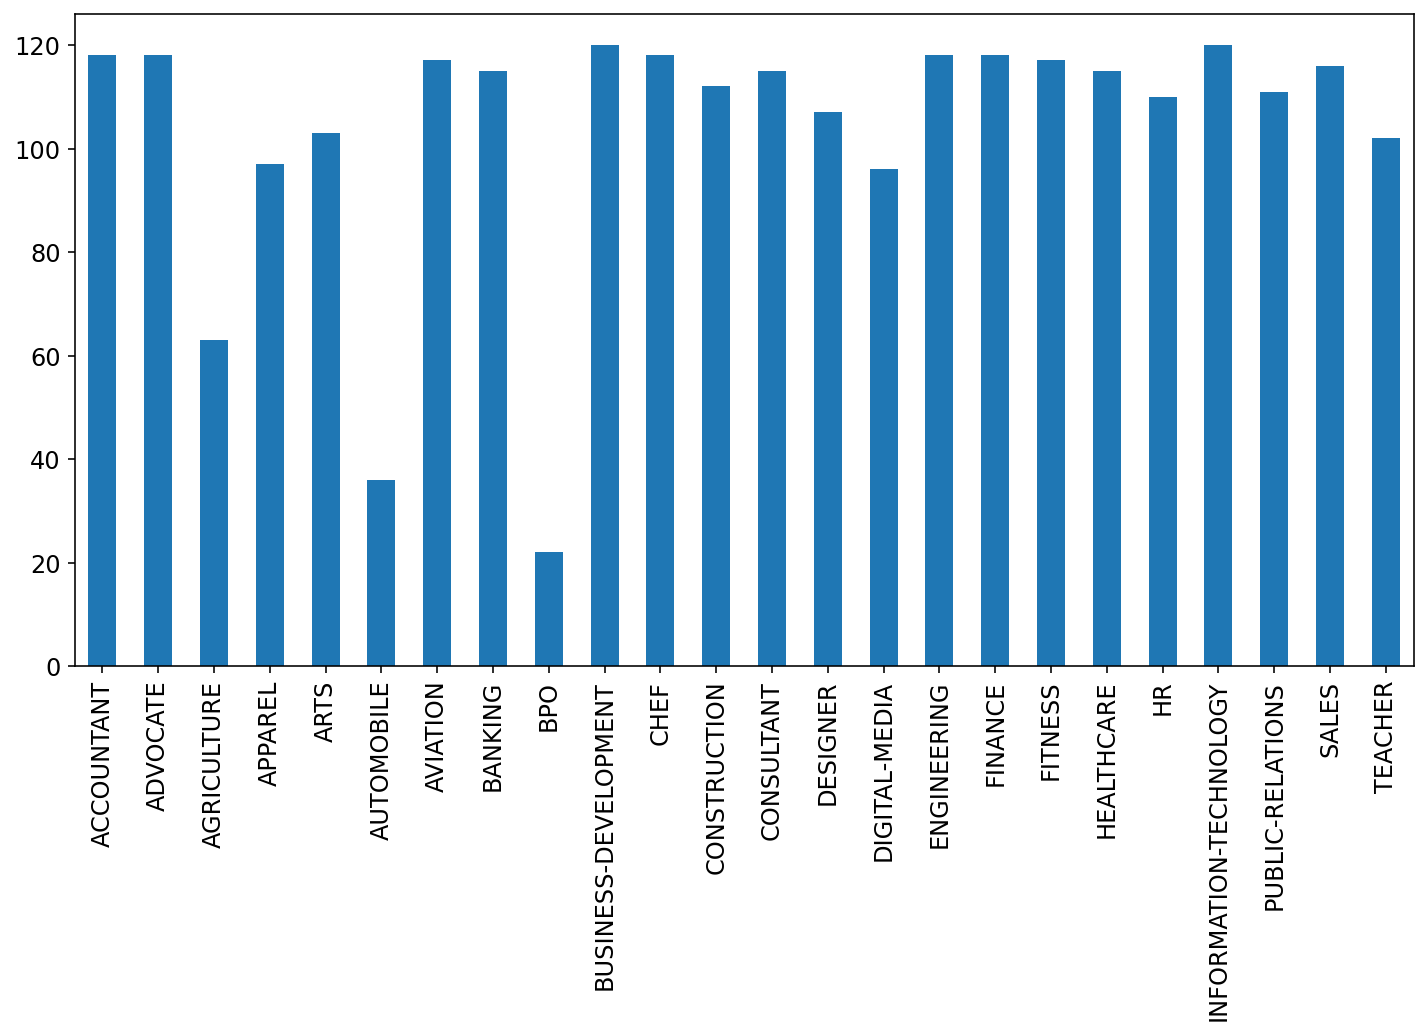

In [ ]:
# Class distribution in dataset 2
df2['Category'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6))
plt.show()

We see that distribution of resumes amongst the various classes in both the datasets is non uniform. 

Resumes belonging to Java Developer, Testing and Devops Engineer seem to dominate the first dataset. 

Resumes belonging to Advocate, Information technology and HR seem to dominate the first dataset. 

This could be attributed maybe because these fields might be high in demand.


Now we will see most frequent keywords per category in both the datasets. This will help us figure out stopwords as well.

In [ ]:
# Returns top 10 frequent words for a given category
def wordfreq(category, df):
    count = df[df['Category'].str.contains(category)]['cleaned_resume'].str.split(expand=True).stack().value_counts().reset_index()
    count.columns = ['Word', 'Frequency']
    return count.head(10)

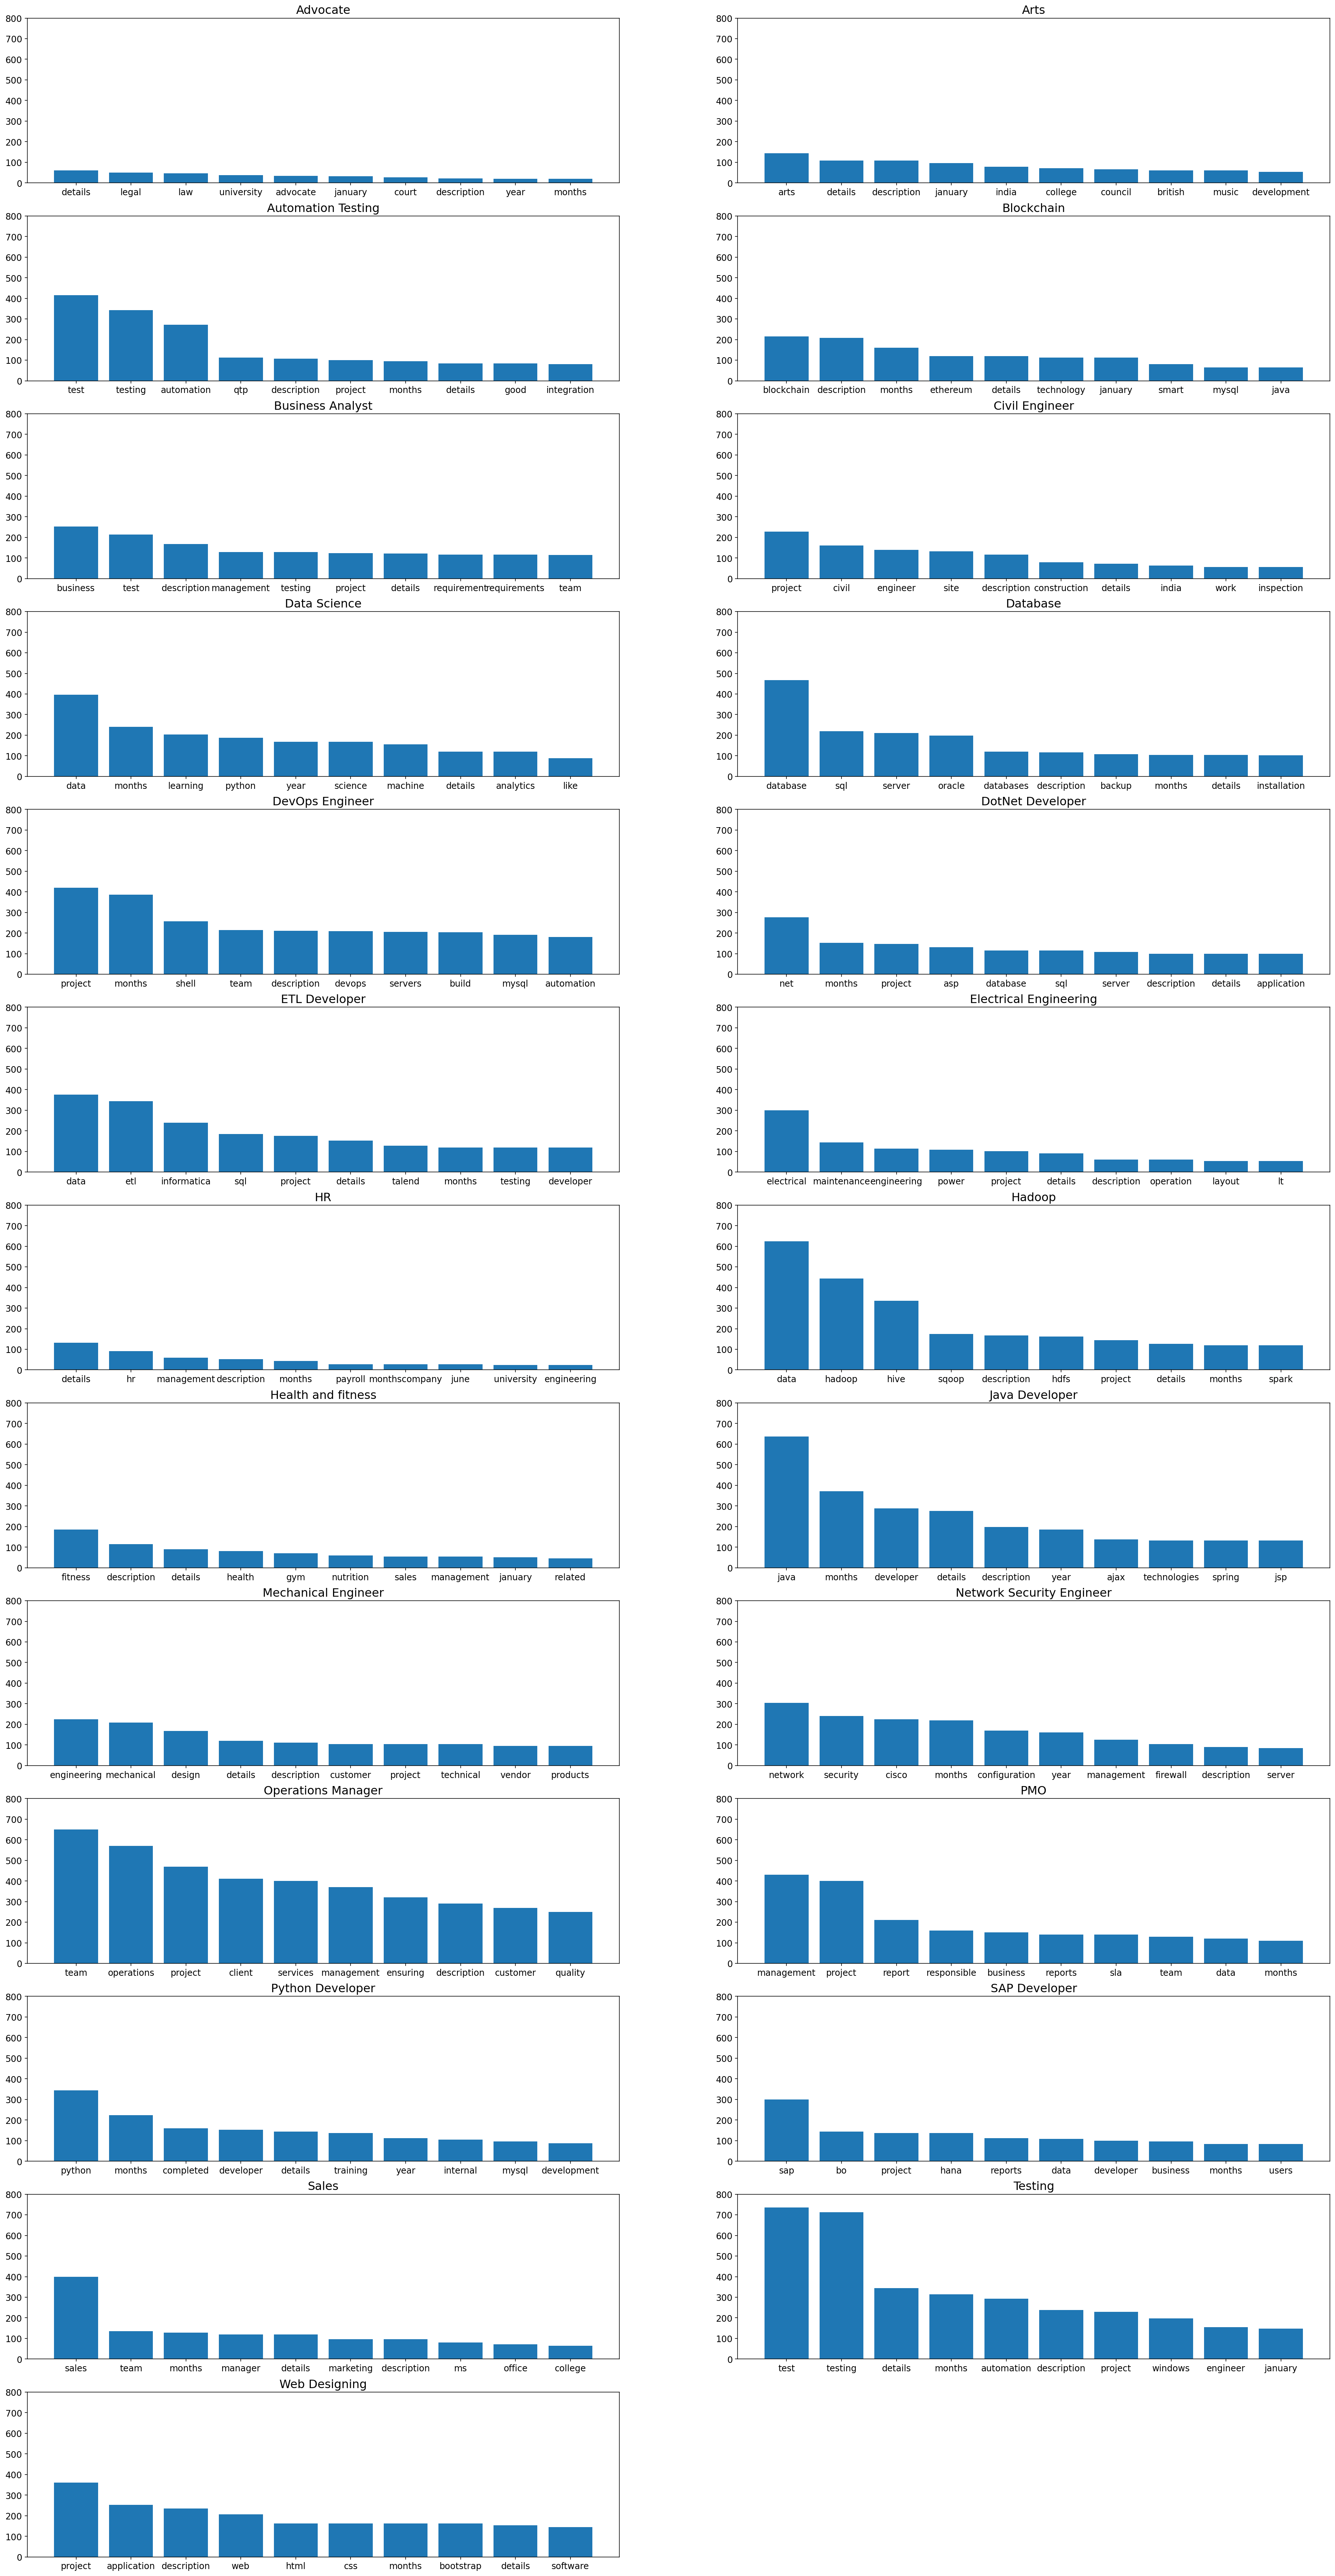

In [ ]:
# Plot top 10 frequent words per category for Dataset 1
fig = plt.figure(figsize=(32, 64))

for i, category in enumerate(np.sort(df['Category'].unique())):
    wf = wordfreq(category, df)
    fig.add_subplot(13, 2, i + 1).set_title(category)
    plt.bar(wf['Word'], wf['Frequency'])
    plt.ylim(0, 800)

plt.show()
plt.close()

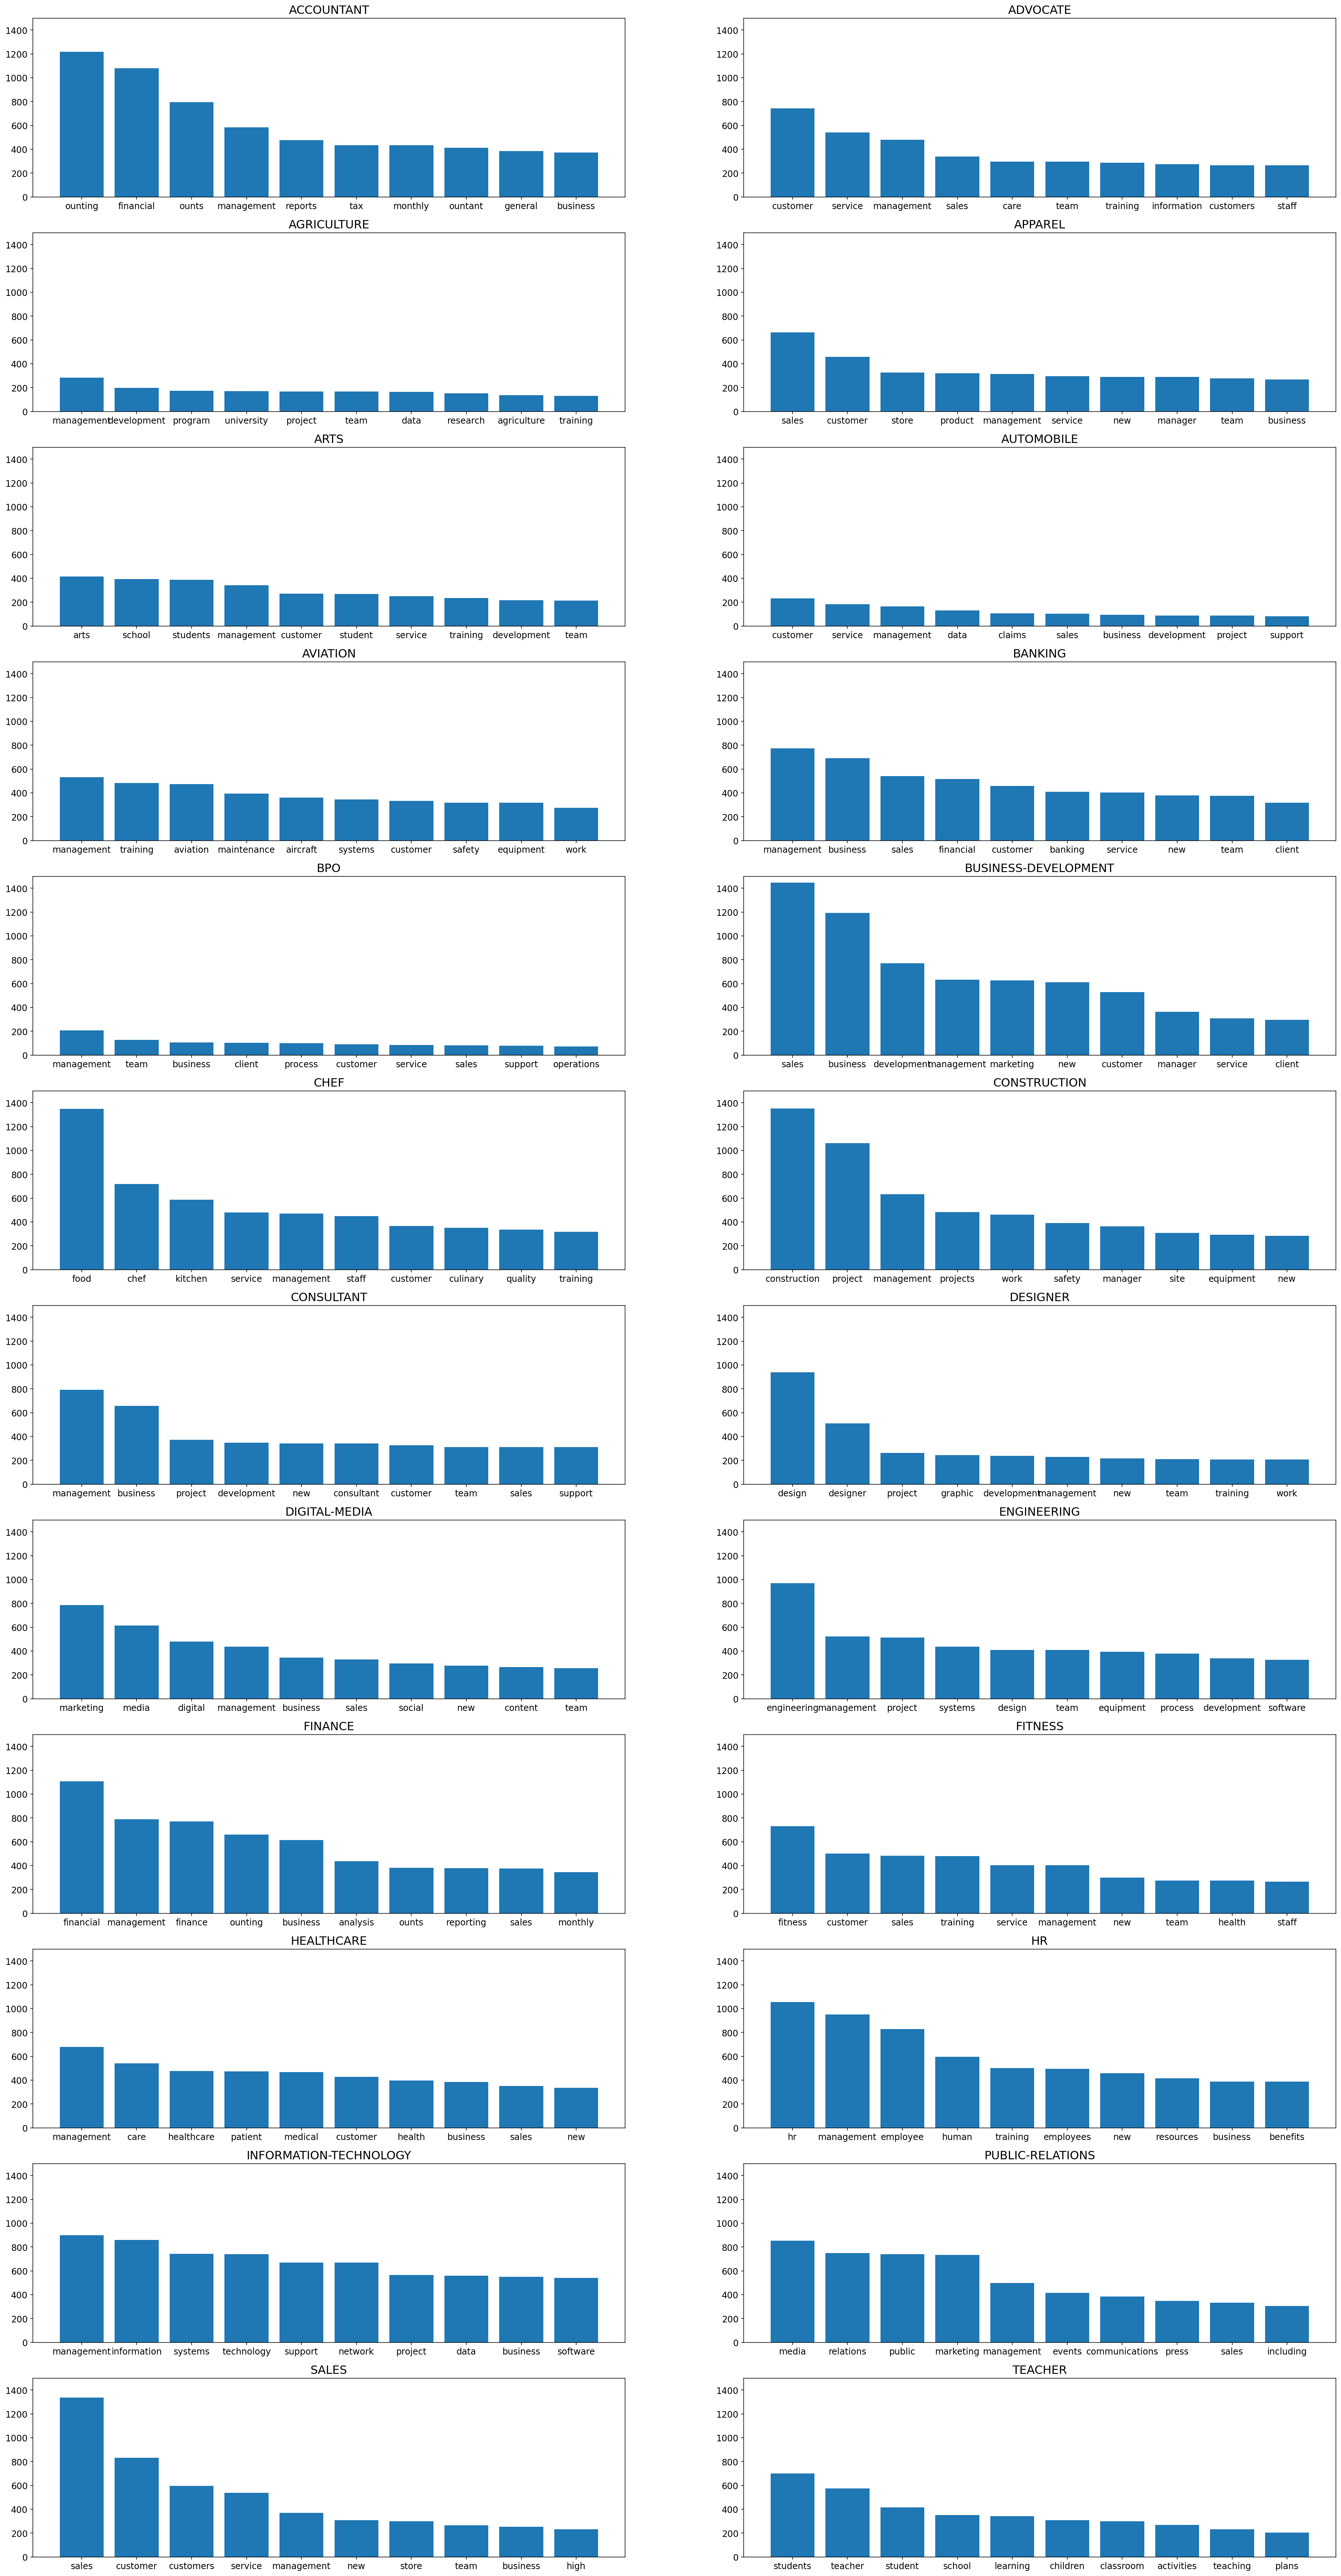

In [ ]:
# Plot top 10 frequent words per category for Dataset 2
fig = plt.figure(figsize=(32, 64))

for i, category in enumerate(np.sort(df2['Category'].unique())):
    wf = wordfreq(category, df2)

    fig.add_subplot(12, 2, i + 1).set_title(category)
    plt.bar(wf['Word'], wf['Frequency'])
    plt.ylim(0, 1500)

plt.show()
plt.close()

## Keyword Analysis

In [ ]:
# Uploading image for word-cloud 
image = np.array(Image.open('s6.webp'))

In [ ]:
# Helper functions to plot word cloud given a dataset
def blue_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(210, 100%%, %d%%)" % random.randint(50, 70)

def plot_word_cloud(df):
  long_string = df['cleaned_resume'].tolist()
  long_string = " ".join(long_string)

  wc = WordCloud(background_color='white', max_words=1500, mask=image)
  wc.generate(long_string)
  fig = plt.figure()
  fig.set_figwidth(8)  # set width
  fig.set_figheight(8)  # set height
  plt.imshow(wc.recolor(color_func=blue_color_func, random_state=3), interpolation="bilinear")
  plt.axis('off')
  plt.show()

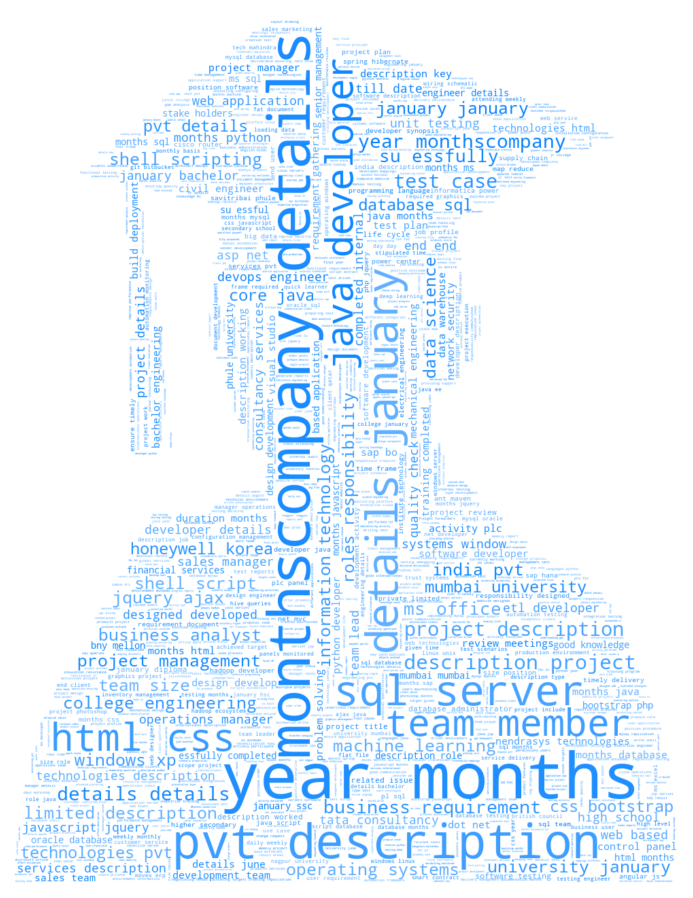

In [ ]:
# Plotting word cloud for first dataset
plot_word_cloud(df)

The word-cloud clearly sheds light on words like  "months", "year", "company", "details", "team" etc which are generally likely to occur in resumes a lot. Most of the resumes have used "company" to define their experience and hence a resume is bound to have the word "company" appearing a lot.

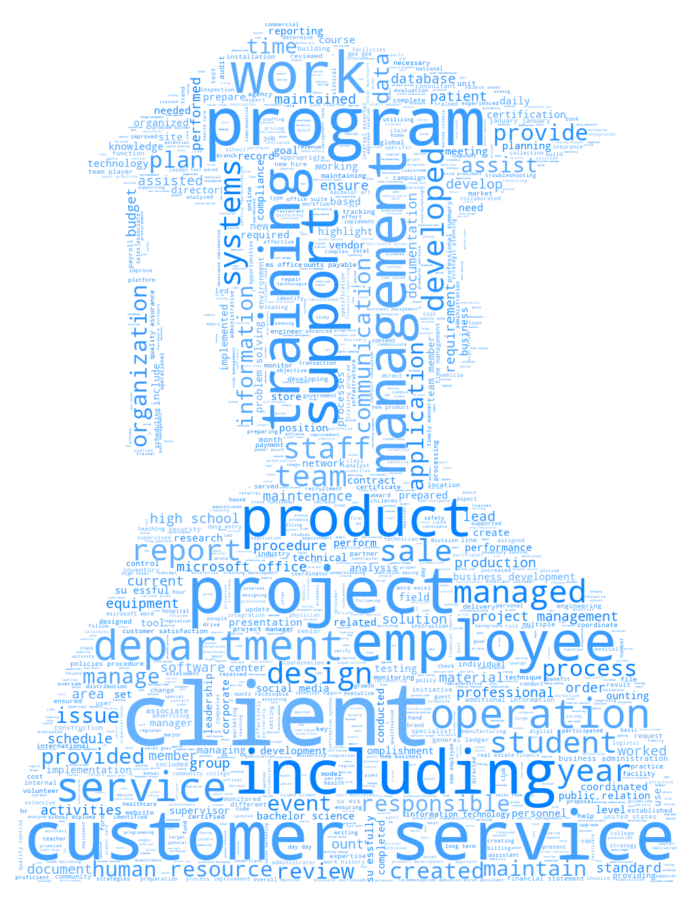

In [ ]:
# Plotting word cloud for second dataset
plot_word_cloud(df2)

The word-cloud clearly sheds light on words like  "client", "customer", "service", "project", "employee" etc which are generally likely to occur in resumes a lot. 

Most of the resumes have used "company" to define their experience and hence a resume is bound to have the word "company" appearing a lot.

There is a difference in most frequent words used in both the datasets because of the distinction in the fields appearing in them. Since, the first one focuses on jobs related to engineering, it is highlighting the general words like compnay, months, details etc.


But, in second resume there is an equla focus on jobs related to non-technical fields along with engineering, so that`s why the most frequent words are client, customer, service etc.

Now we will look at most common keywords in each dataset and their frequencies. In turn, we can find more stopwords.  This will help us to get an idea what general words are being used by most of resume despite their field.

In [ ]:
# Functions to draw bar graph and pie chart for most frequent words in entire resume column of dataset
def plot_bar_pie(df):
  df_temp = df.copy()
  long_string = df_temp['cleaned_resume'].tolist()
  r_list=[]
  for item in long_string:
    item = item.split()
    for i in item:
      r_list.append(i)
  
  counts = Counter(r_list)
  df_temp = pd.DataFrame.from_dict(counts, orient='index').reset_index()
  df_temp.columns = ['Words', 'Count']
  df_temp.sort_values(by='Count', ascending=False, inplace=True)

  colors = ['rgb(8,48,107)', 'rgb(8,81,156)', 'rgb(33,113,181)', 'rgb(66,146,198)','rgb(107,174,214)', 'rgb(158,202,225)',
          'rgb(198,219,239)','rgb(222,235,247)', 'rgb(247,251,255)', 'rgb(247,253,255)']
  fig = make_subplots(rows=1, cols=2, specs=[[{"type": "xy"}, { "type": "domain"}]],vertical_spacing=0.001,)
  fig.add_trace(go.Bar(x = df_temp['Count'].head(10), y=df_temp['Words'].head(10),marker=dict(color='rgba(66,146,198, 1)',
                                                                                  line=dict(color='Black'),),name='Bar Chart',orientation='h'), 1, 1)
  fig.add_trace(go.Pie(labels=df_temp['Words'].head(10),values=df_temp['Count'].head(15),
                     textinfo='label+percent',insidetextorientation='radial', 
                     marker=dict(colors=colors, line=dict(color='DarkSlateGrey')),name='Pie Chart'), 1, 2)
  fig.update_layout(shapes=[dict(type="line",xref="paper", yref="paper", x0=0.5, y0=0, x1=0.5, y1=1.0,line_color='DarkSlateGrey', line_width=1)])
  fig.update_layout(showlegend=False, title=dict(text="10 Most Common Words used in Resume",font=dict(size=8)))
  fig.update_layout(height=400, width=1200,yaxis=dict(showgrid=False,
                             showline=False,
                             showticklabels=True,
                             domain=[0, 1],
                             categoryorder='total ascending',
                             title=dict(text='Common Words', font_size=14)),
                             xaxis=dict(zeroline=False,
                             showline=False,
                             showticklabels=True,
                             showgrid=True,
                             domain=[0, 0.42],
                             title=dict(text='Word Count', font_size=14)),
                             margin=dict(l=100, r=20, t=70, b=70),
                             paper_bgcolor='rgba(0,0,0,0)',
                             plot_bgcolor='rgba(0,0,0,0)')
  x = df_temp['Count'].head(10).to_list()
  y = df_temp['Words'].head(10).to_list()
  annotations = [dict(xref='x1', yref='y1', x=xa + 350, y=ya, text=str(xa), showarrow=False) for xa, ya in zip(x, y)]
  fig.update_layout(annotations=annotations)
  return(fig)

In [ ]:
# Pie chart and bar graph of most frequent words in dataset 1
plot_bar_pie(df)

In [ ]:
# Pie chart and bar graph of most frequent words in dataset 2
plot_bar_pie(df2)

Now we will check for coorelation between various keywords in both the datasets.

In [ ]:
# Function to find correlated words per category by printing unigrams and bigrams
N = 2
def unigram_bigram(df):
  df1 = df.copy()
  df1['category_id'] = df1['Category'].factorize()[0]
  tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1,2), stop_words='english')
  features = tfidf.fit_transform(df.Resume).toarray()
  labels = df1.category_id
  features.shape
  col = ['Category', 'Resume']
  df1 = df1[col]
  df1 = df1[pd.notnull(df['Resume'])]
  df1.columns = ['Category', 'Resume']
  df1['category_id'] = df1['Category'].factorize()[0]
  category_id_df = df1[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
  category_to_id = dict(category_id_df.values)
  id_to_category = dict(category_id_df[['category_id', 'Category']].values)
  for Category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Category))
    print("  . Most correlated unigrams:\n\t. {}".format('\n\t. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n\t. {}".format('\n\t. '.join(bigrams[-N:])))
    print("\n\n")


In [ ]:
# For dataset1
unigram_bigram(df)

# 'Advocate':
  . Most correlated unigrams:
	. law
	. advocate
  . Most correlated bigrams:
	. university advocate
	. advocate skill



# 'Arts':
  . Most correlated unigrams:
	. karate
	. arts
  . Most correlated bigrams:
	. arts craft
	. craft teacher



# 'Automation Testing':
  . Most correlated unigrams:
	. selenium
	. box
  . Most correlated bigrams:
	. automation testing
	. manual automation



# 'Blockchain':
  . Most correlated unigrams:
	. ethereum
	. blockchain
  . Most correlated bigrams:
	. smart contracts
	. blockchain developer



# 'Business Analyst':
  . Most correlated unigrams:
	. mms
	. analyst
  . Most correlated bigrams:
	. analyst business
	. business analyst



# 'Civil Engineer':
  . Most correlated unigrams:
	. construction
	. civil
  . Most correlated bigrams:
	. site engineer
	. civil engineer



# 'Data Science':
  . Most correlated unigrams:
	. deep
	. learning
  . Most correlated bigrams:
	. machine learning
	. data science



# 'Database':
  . Most corre

In [ ]:
# For dataset2
unigram_bigram(df2)

# 'ACCOUNTANT':
  . Most correlated unigrams:
	. ledger
	. accountant
  . Most correlated bigrams:
	. general ledger
	. accountant summary



# 'ADVOCATE':
  . Most correlated unigrams:
	. advocacy
	. advocate
  . Most correlated bigrams:
	. advocate professional
	. advocate summary



# 'AGRICULTURE':
  . Most correlated unigrams:
	. agricultural
	. agriculture
  . Most correlated bigrams:
	. agriculture education
	. natural resources



# 'APPAREL':
  . Most correlated unigrams:
	. merchandising
	. apparel
  . Most correlated bigrams:
	. apparel sales
	. assistant buyer



# 'ARTS':
  . Most correlated unigrams:
	. arts
	. martial
  . Most correlated bigrams:
	. language arts
	. arts teacher



# 'AUTOMOBILE':
  . Most correlated unigrams:
	. insureds
	. automobile
  . Most correlated bigrams:
	. injury claims
	. liability claims



# 'AVIATION':
  . Most correlated unigrams:
	. aircraft
	. aviation
  . Most correlated bigrams:
	. aviation supply
	. aviation maintenance



# 'BANKING

Now we will analysise the resumes to find what adjectives are people using to describe themselves and their works. This is a good piece of information to know where ones resume stand. 

In [ ]:
# Code to print adjective cloud
image1 = np.array(Image.open('s7.jpg')) 
sw = STOPWORDS.union(set(string.punctuation))
def pos_tag(s):
    return nltk.pos_tag(s)

def plot_adjective_cloud(df):
  length = df.shape
  eval_res = df["cleaned_resume"].copy(deep=True)
  adj_list={}
  for i in range(length[0]):
    token = nltk.word_tokenize(eval_res[i])
    pos_token = pos_tag(token)
    for i,tag in pos_token:
      if tag in ["JJ","JJR","JJS"]:
        if i in adj_list:
          adj_list[i]+=1
        else:
          adj_list[i] = 1
  wc = WordCloud(background_color='white', stopwords = sw, max_words=1500, mask=image1).generate_from_frequencies(adj_list)
  fig = plt.figure()
  fig.set_figwidth(8)  # set width
  fig.set_figheight(8)  # set height
  plt.imshow(wc.recolor(color_func=blue_color_func, random_state=3), interpolation="bilinear")
  plt.axis('off')
  plt.show()


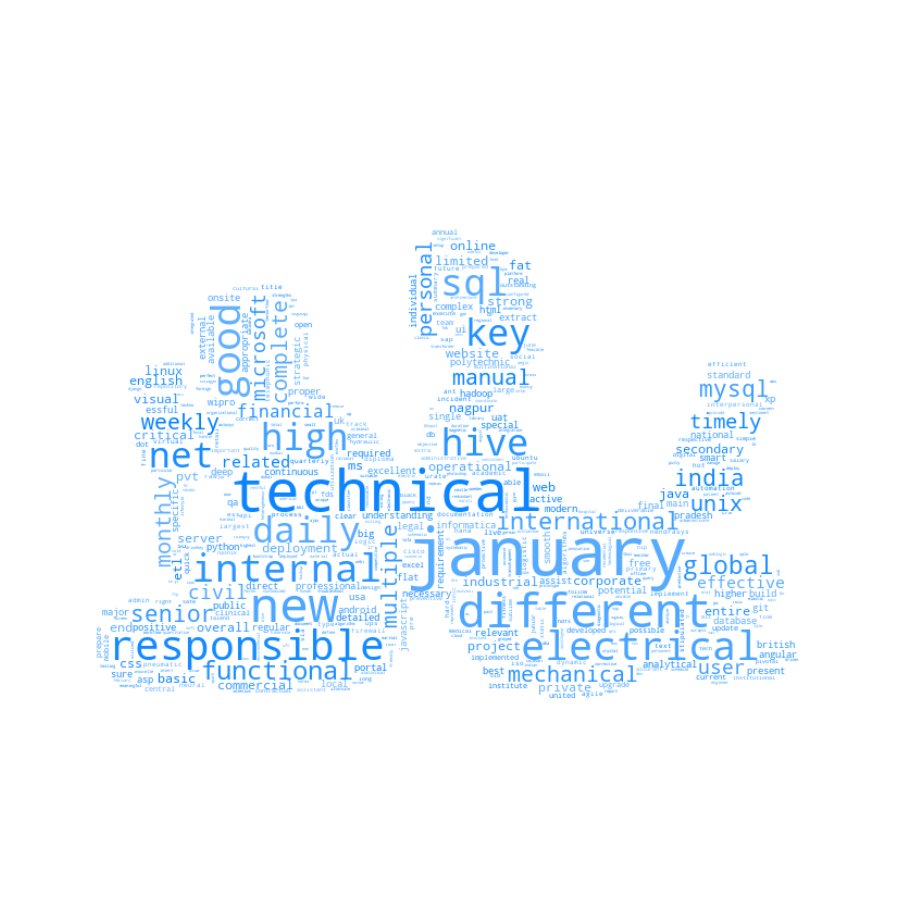

In [ ]:
# Adjective cloud for datatset 1
plot_adjective_cloud(df)

Words like technical, responsible, good, senior which are quiet prominent in the wordcloud, could have been mainly used in describing oneself.

Words like daily, multiple, international, monthly, financial, functional etc couldve been used to exaplin about the past designations/jobs/income etc.

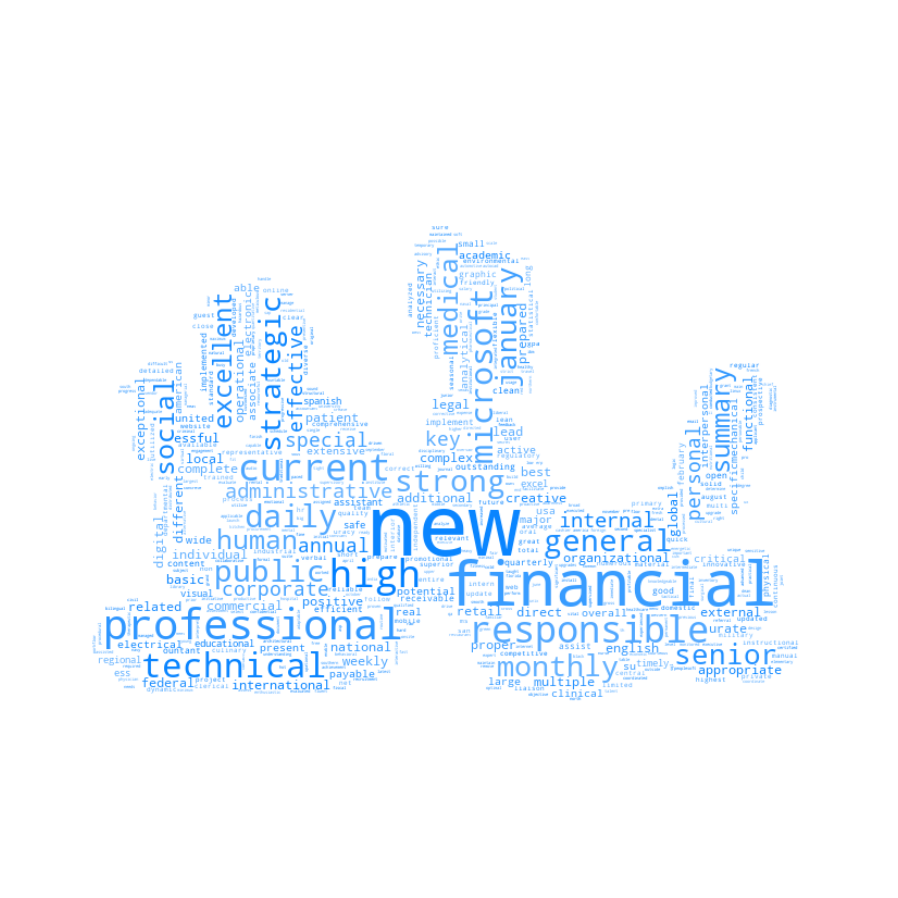

In [ ]:
# Adjective cloud for datatset 2
plot_adjective_cloud(df2)

Words like professional, new, responsible, senior which are quiet prominent in the wordcloud, could have been mainly used in describing oneself.

Words like financial, general, current, technical, daily etc couldve been used to exaplin about the past designations/jobs/income etc.

# Classification

## Train Test Split and Vectorization 

We are using TD-IDF to vectorize the resume text in order to obtain features for training classification models.

We use TF-IDF in particular as it will help us give high weightage to specialized keywoards and low score to more common words which don't add much value to the prediction. 

In [ ]:
# intialize TD-IDF Vectorizer to vectorize the textual data to obtain features for classification
vecDF1 = TfidfVectorizer(stop_words='english', max_features=1500, sublinear_tf=True)
vecDF2 = TfidfVectorizer(stop_words='english', max_features=1500, sublinear_tf=True)

# Train test split in 70:30 ratio
# Also Stratify by Category column to make sure Train and Test splits are representative of the actual dataset
tfidf_train_data, tfidf_test_data, y_train, y_test = train_test_split(vecDF1.fit_transform(df['cleaned_resume']), df['Category'], stratify = df['Category'], test_size=0.3, random_state = RANDOM_SEED)

# train test split for 2nd dataset
tfidf_train_data2, tfidf_test_data2, y_train2, y_test2 = train_test_split(vecDF2.fit_transform(df2['cleaned_resume']), df2['Category'], stratify = df2['Category'], test_size=0.3, random_state = RANDOM_SEED)

## Baseline performance Tests on Classification Algorithms

Firstly, we will perform baseline performnce tests on different algorithms to find out how they perform and whether they are suited for this problem or not. 

In [ ]:
baselineResultsDF1 = []
baselineResultsDF2 = []

# Function takes classifier as input, trains it on training split and prints metrics on test split
def evaluateClassifier(classifierName,classifier, tfidf_train_data, y_train, tfidf_test_data, y_test, isdf1):
  classifier = classifier.fit(tfidf_train_data, y_train)
  predicted = classifier.predict(tfidf_test_data)
  predicted_prob = classifier.predict_proba(tfidf_test_data)
  a= pd.DataFrame(y_test)
  a['predicted'] = predicted
  a.head()
  accuracy=accuracy_score(a.Category, a.predicted)
  f1Score = metrics.f1_score(a.Category,a.predicted,average='weighted')
  auc = metrics.roc_auc_score(a.Category, predicted_prob, multi_class="ovr")
  print(f"Accuracy from {classifierName}: {accuracy}")  
  print(f"F1 Weighted Score from {classifierName}: {f1Score}")  
  print("Auc:", round(auc,2))
  if isdf1:
    baselineResultsDF1.append([classifierName,accuracy,f1Score,auc])
  else:
    baselineResultsDF2.append([classifierName,accuracy,f1Score,auc])
  print('Classification Report:\n')
  print(metrics.classification_report(a.Category, a.predicted, target_names=y_train.unique()))

### Naive Bayes




In [ ]:
# Running the Multinomia Naive Bayes Classifier on dataset1
classifier = MultinomialNB()
evaluateClassifier('NaiveBayes',classifier, tfidf_train_data, y_train, tfidf_test_data, y_test, True)

Accuracy from NaiveBayes: 0.9515570934256056
F1 Weighted Score from NaiveBayes: 0.9500358003905105
Auc: 1.0
Classification Report:

                           precision    recall  f1-score   support

                    Sales       1.00      0.67      0.80         6
         Python Developer       1.00      1.00      1.00        11
                   Hadoop       1.00      0.62      0.77         8
             Data Science       1.00      1.00      1.00        12
       Automation Testing       1.00      0.88      0.93         8
      Mechanical Engineer       1.00      1.00      1.00         7
           Civil Engineer       1.00      0.92      0.96        12
       Operations Manager       1.00      1.00      1.00        10
               Blockchain       1.00      0.94      0.97        17
                       HR       1.00      0.50      0.67         8
            ETL Developer       1.00      1.00      1.00        12
                     Arts       1.00      1.00      1.00       

In [ ]:
# Running and evaluating the Naive Bayes  model on Dataset 2
evaluateClassifier('NaiveBayes',classifier, tfidf_train_data2, y_train2, tfidf_test_data2, y_test2, False)

Accuracy from NaiveBayes: 0.5361930294906166
F1 Weighted Score from NaiveBayes: 0.4976190237607212
Auc: 0.91
Classification Report:

                        precision    recall  f1-score   support

            CONSULTANT       0.45      0.86      0.59        35
           AGRICULTURE       0.38      0.37      0.38        35
         DIGITAL-MEDIA       1.00      0.11      0.19        19
               BANKING       0.60      0.10      0.18        29
               FINANCE       0.33      0.06      0.11        31
                  CHEF       0.00      0.00      0.00        11
              DESIGNER       0.66      0.60      0.63        35
            HEALTHCARE       0.60      0.43      0.50        35
      PUBLIC-RELATIONS       0.00      0.00      0.00         7
               TEACHER       0.40      0.64      0.49        36
               FITNESS       0.74      0.80      0.77        35
                    HR       0.75      0.71      0.73        34
              AVIATION       0.33 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### SVM


In [ ]:
# Running and evaluating the SVM  model on Dataset 1
classifier = SVC(kernel='linear', probability=True, random_state=RANDOM_SEED)
evaluateClassifier('SVM',classifier, tfidf_train_data, y_train, tfidf_test_data, y_test, True)

Accuracy from SVM: 0.9965397923875432
F1 Weighted Score from SVM: 0.9965891358116068
Auc: 1.0
Classification Report:

                           precision    recall  f1-score   support

                    Sales       1.00      1.00      1.00         6
         Python Developer       1.00      1.00      1.00        11
                   Hadoop       0.89      1.00      0.94         8
             Data Science       1.00      1.00      1.00        12
       Automation Testing       1.00      1.00      1.00         8
      Mechanical Engineer       1.00      1.00      1.00         7
           Civil Engineer       1.00      1.00      1.00        12
       Operations Manager       1.00      1.00      1.00        10
               Blockchain       1.00      0.94      0.97        17
                       HR       1.00      1.00      1.00         8
            ETL Developer       1.00      1.00      1.00        12
                     Arts       1.00      1.00      1.00         9
          

In [ ]:
# Running and evaluating the SVM  model on Dataset 2

evaluateClassifier('SVM',classifier, tfidf_train_data2, y_train2, tfidf_test_data2, y_test2, False)

Accuracy from SVM: 0.6246648793565683
F1 Weighted Score from SVM: 0.6125300040197748
Auc: 0.94
Classification Report:

                        precision    recall  f1-score   support

            CONSULTANT       0.65      0.86      0.74        35
           AGRICULTURE       0.53      0.46      0.49        35
         DIGITAL-MEDIA       0.55      0.32      0.40        19
               BANKING       0.47      0.31      0.38        29
               FINANCE       0.35      0.26      0.30        31
                  CHEF       1.00      0.09      0.17        11
              DESIGNER       0.74      0.57      0.65        35
            HEALTHCARE       0.67      0.63      0.65        35
      PUBLIC-RELATIONS       0.00      0.00      0.00         7
               TEACHER       0.55      0.61      0.58        36
               FITNESS       0.88      0.80      0.84        35
                    HR       0.82      0.79      0.81        34
              AVIATION       0.41      0.37     

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### KNN



In [ ]:
# Running and evaluating the KNN  model on Dataset 1
classifier = KNeighborsClassifier()
evaluateClassifier('KNN',classifier, tfidf_train_data, y_train, tfidf_test_data, y_test, True)

Accuracy from KNN: 0.9688581314878892
F1 Weighted Score from KNN: 0.9678961810879547
Auc: 1.0
Classification Report:

                           precision    recall  f1-score   support

                    Sales       1.00      1.00      1.00         6
         Python Developer       1.00      1.00      1.00        11
                   Hadoop       0.88      0.88      0.88         8
             Data Science       1.00      1.00      1.00        12
       Automation Testing       1.00      1.00      1.00         8
      Mechanical Engineer       1.00      1.00      1.00         7
           Civil Engineer       1.00      0.83      0.91        12
       Operations Manager       1.00      1.00      1.00        10
               Blockchain       1.00      0.88      0.94        17
                       HR       1.00      1.00      1.00         8
            ETL Developer       1.00      1.00      1.00        12
                     Arts       0.90      1.00      0.95         9
          

In [ ]:
# Running and evaluating the KNN  model on Dataset 2
evaluateClassifier('KNN',classifier, tfidf_train_data2, y_train2, tfidf_test_data2, y_test2, False)

Accuracy from KNN: 0.5214477211796247
F1 Weighted Score from KNN: 0.5121654551637592
Auc: 0.81
Classification Report:

                        precision    recall  f1-score   support

            CONSULTANT       0.45      0.80      0.58        35
           AGRICULTURE       0.22      0.37      0.27        35
         DIGITAL-MEDIA       0.38      0.32      0.34        19
               BANKING       0.35      0.31      0.33        29
               FINANCE       0.48      0.35      0.41        31
                  CHEF       0.33      0.09      0.14        11
              DESIGNER       0.62      0.57      0.60        35
            HEALTHCARE       0.59      0.49      0.53        35
      PUBLIC-RELATIONS       0.00      0.00      0.00         7
               TEACHER       0.39      0.36      0.38        36
               FITNESS       0.76      0.80      0.78        35
                    HR       0.66      0.74      0.69        34
              AVIATION       0.22      0.17     

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### Random Forest Classifier




In [ ]:
# Running and evaluating the RandomForest model on Dataset 1

classifier=RandomForestClassifier()
evaluateClassifier('RandomForest',classifier, tfidf_train_data, y_train, tfidf_test_data, y_test, True)

Accuracy from RandomForest: 0.9930795847750865
F1 Weighted Score from RandomForest: 0.9930668634235701
Auc: 1.0
Classification Report:

                           precision    recall  f1-score   support

                    Sales       1.00      1.00      1.00         6
         Python Developer       1.00      1.00      1.00        11
                   Hadoop       0.89      1.00      0.94         8
             Data Science       1.00      1.00      1.00        12
       Automation Testing       1.00      1.00      1.00         8
      Mechanical Engineer       1.00      1.00      1.00         7
           Civil Engineer       1.00      1.00      1.00        12
       Operations Manager       1.00      1.00      1.00        10
               Blockchain       1.00      0.88      0.94        17
                       HR       0.89      1.00      0.94         8
            ETL Developer       1.00      1.00      1.00        12
                     Arts       1.00      1.00      1.00   

In [ ]:
# Running and evaluating the RandomForest  model on Dataset 2
evaluateClassifier('RandomForest',classifier, tfidf_train_data2, y_train2, tfidf_test_data2, y_test2, False)

Accuracy from RandomForest: 0.660857908847185
F1 Weighted Score from RandomForest: 0.6348246789542498
Auc: 0.94
Classification Report:

                        precision    recall  f1-score   support

            CONSULTANT       0.68      0.91      0.78        35
           AGRICULTURE       0.68      0.71      0.69        35
         DIGITAL-MEDIA       0.75      0.16      0.26        19
               BANKING       0.50      0.24      0.33        29
               FINANCE       0.58      0.23      0.33        31
                  CHEF       0.00      0.00      0.00        11
              DESIGNER       0.84      0.89      0.86        35
            HEALTHCARE       0.61      0.57      0.59        35
      PUBLIC-RELATIONS       0.00      0.00      0.00         7
               TEACHER       0.53      0.50      0.51        36
               FITNESS       0.79      0.89      0.84        35
                    HR       0.78      0.94      0.85        34
              AVIATION       0.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### Logistic Regression

In [ ]:
# Running and evaluating the LogisticRegression model on Dataset 1

lr_model =  LogisticRegression(multi_class='ovr', solver='liblinear')
evaluateClassifier('LogisticRegression',lr_model, tfidf_train_data, y_train, tfidf_test_data, y_test, True)

Accuracy from LogisticRegression: 0.9896193771626297
F1 Weighted Score from LogisticRegression: 0.9895280958859596
Auc: 1.0
Classification Report:

                           precision    recall  f1-score   support

                    Sales       1.00      1.00      1.00         6
         Python Developer       1.00      1.00      1.00        11
                   Hadoop       0.88      0.88      0.88         8
             Data Science       1.00      1.00      1.00        12
       Automation Testing       1.00      1.00      1.00         8
      Mechanical Engineer       1.00      1.00      1.00         7
           Civil Engineer       1.00      1.00      1.00        12
       Operations Manager       1.00      1.00      1.00        10
               Blockchain       1.00      0.88      0.94        17
                       HR       1.00      1.00      1.00         8
            ETL Developer       1.00      1.00      1.00        12
                     Arts       0.90      1.00 

In [ ]:
# Running and evaluating the LogisticRegression model on Dataset 2
evaluateClassifier('LogisticRegression',lr_model, tfidf_train_data2, y_train2, tfidf_test_data2, y_test2, False)

Accuracy from LogisticRegression: 0.6233243967828418
F1 Weighted Score from LogisticRegression: 0.599786243753331
Auc: 0.94
Classification Report:

                        precision    recall  f1-score   support

            CONSULTANT       0.64      0.86      0.73        35
           AGRICULTURE       0.50      0.46      0.48        35
         DIGITAL-MEDIA       1.00      0.21      0.35        19
               BANKING       0.69      0.31      0.43        29
               FINANCE       0.50      0.16      0.24        31
                  CHEF       0.00      0.00      0.00        11
              DESIGNER       0.79      0.63      0.70        35
            HEALTHCARE       0.65      0.57      0.61        35
      PUBLIC-RELATIONS       0.00      0.00      0.00         7
               TEACHER       0.45      0.56      0.50        36
               FITNESS       0.83      0.83      0.83        35
                    HR       0.76      0.85      0.81        34
              AVIAT

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## Hyperparameter Tuning

In [ ]:
# Placeholder to store tuning results as a table
tuningResultsDF1 = []
tuningResultsDF2 = []

# Function to evaluate a given model on test dataset and claculate evaluation metrics
def evaluateModelPerformance(modelName, model, test_features, test_labels,isdf1):
    predictions = model.predict(test_features)
    accuracy=accuracy_score(test_labels, predictions)
    f1Score = metrics.f1_score(test_labels,predictions,average='weighted')
    print('Model Performance for ' + modelName)
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print('F1_Weighted Score = {:0.2f}%.'.format(f1Score))
    print('Classification Report:\n')
    print(metrics.classification_report(test_labels, predictions, target_names=test_labels.unique()))
    if isdf1:
      tuningResultsDF1.append([modelName,model.get_params(),accuracy,f1Score])
    else:
      tuningResultsDF2.append([modelName,model.get_params(),accuracy,f1Score])

# Function taken in a classifier and does 10 fold CV on training split to find best hyperparameters
# Then calls evaluateModelPerformance() to calculate metrics on test split
def hyperparameter_tuning_using_CV(classifierName, classifier, parameterGrid, tfidf_train_data, y_train, tfidf_test_data, y_test, isdf1):
  grid_search = GridSearchCV(
    classifier, parameterGrid, cv=10, scoring="f1_weighted", return_train_score=True
  )
  grid_search = grid_search.fit(tfidf_train_data, y_train)
  best_params = grid_search.best_params_
  print(f"Best Parameter based on Grid Search: ", best_params)
  print(f"Best F1 Weighted Score based on Grid Search: ", grid_search.best_score_)
  # Evaluate best model on test split and store results
  classifier = classifier.set_params(**best_params)
  classifier = classifier.fit(tfidf_train_data, y_train)
  evaluateModelPerformance(classifierName,classifier,tfidf_test_data,y_test,isdf1)

### Random Forest

In [ ]:
random_forest = RandomForestClassifier()

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [ ]:
# Training the hyper parameterised model on RandomForest for dataset 1

hyperparameter_tuning_using_CV('RandomForest',random_forest, param_grid, tfidf_train_data, y_train, tfidf_test_data, y_test, True)

Best Parameter based on Grid Search:  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 500}
Best F1 Weighted Score based on Grid Search:  0.9818171955836574
Model Performance for RandomForest
Accuracy = 0.98%.
F1_Weighted Score = 0.97%.
Classification Report:

                           precision    recall  f1-score   support

            Web Designing       1.00      0.17      0.29         6
                   Hadoop       1.00      1.00      1.00        11
            ETL Developer       0.89      1.00      0.94         8
      Mechanical Engineer       1.00      1.00      1.00        12
                  Testing       1.00      1.00      1.00         8
           Civil Engineer       1.00      1.00      1.00         7
   Electrical Engineering       1.00      1.00      1.00        12
          DevOps Engineer       1.00      1.00      1.00        10
         Python Developer       1.00      0.88      0.94        17
         DotNet Developer       1.00   

In [ ]:
# Training the hyper parameterised model on RandomForest for dataset 2

hyperparameter_tuning_using_CV('RandomForest',random_forest, param_grid, tfidf_train_data2, y_train2, tfidf_test_data2, y_test2, False)

Best Parameter based on Grid Search:  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}
Best F1 Weighted Score based on Grid Search:  0.6217560294972614
Model Performance for RandomForest
Accuracy = 0.64%.
F1_Weighted Score = 0.59%.
Classification Report:

                        precision    recall  f1-score   support

                  CHEF       0.55      0.91      0.69        35
           AGRICULTURE       0.65      0.63      0.64        35
               FITNESS       0.00      0.00      0.00        19
INFORMATION-TECHNOLOGY       1.00      0.03      0.07        29
               FINANCE       0.33      0.03      0.06        31
            HEALTHCARE       0.00      0.00      0.00        11
  BUSINESS-DEVELOPMENT       0.82      0.91      0.86        35
            CONSULTANT       0.62      0.43      0.51        35
                 SALES       0.00      0.00      0.00         7
                  ARTS       0.52      0.47      0.49        36
     

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### SVM



In [ ]:
# Hyperparameter tuning for SVM
svm_classifier= SVC(random_state=RANDOM_SEED)

svm_param_grid = {'C': [0.1,1, 10, 100],'kernel': ['linear','poly']}

In [ ]:
# Training the hyper parameterised model on svm for dataset 1
hyperparameter_tuning_using_CV('SVM',svm_classifier, svm_param_grid, tfidf_train_data, y_train, tfidf_test_data, y_test, True)

Best Parameter based on Grid Search:  {'C': 1, 'kernel': 'linear'}
Best F1 Weighted Score based on Grid Search:  0.9922300504587598
Model Performance for SVM
Accuracy = 1.00%.
F1_Weighted Score = 1.00%.
Classification Report:

                           precision    recall  f1-score   support

            Web Designing       1.00      1.00      1.00         6
                   Hadoop       1.00      1.00      1.00        11
            ETL Developer       0.89      1.00      0.94         8
      Mechanical Engineer       1.00      1.00      1.00        12
                  Testing       1.00      1.00      1.00         8
           Civil Engineer       1.00      1.00      1.00         7
   Electrical Engineering       1.00      1.00      1.00        12
          DevOps Engineer       1.00      1.00      1.00        10
         Python Developer       1.00      0.94      0.97        17
         DotNet Developer       1.00      1.00      1.00         8
                 Database       1.0

In [ ]:
# Training the hyper parameterised model on svm for dataset 2
hyperparameter_tuning_using_CV('SVM',svm_classifier, svm_param_grid, tfidf_train_data2, y_train2, tfidf_test_data2, y_test2, False)

Best Parameter based on Grid Search:  {'C': 10, 'kernel': 'linear'}
Best F1 Weighted Score based on Grid Search:  0.6423072735238554
Model Performance for SVM
Accuracy = 0.65%.
F1_Weighted Score = 0.64%.
Classification Report:

                        precision    recall  f1-score   support

                  CHEF       0.64      0.77      0.70        35
           AGRICULTURE       0.51      0.54      0.53        35
               FITNESS       0.56      0.47      0.51        19
INFORMATION-TECHNOLOGY       0.32      0.24      0.27        29
               FINANCE       0.34      0.32      0.33        31
            HEALTHCARE       0.43      0.27      0.33        11
  BUSINESS-DEVELOPMENT       0.83      0.69      0.75        35
            CONSULTANT       0.70      0.66      0.68        35
                 SALES       0.00      0.00      0.00         7
                  ARTS       0.58      0.61      0.59        36
            ACCOUNTANT       0.88      0.83      0.85        35
   

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### KNN

In [ ]:
knn_classifier = KNeighborsClassifier()

knn_param_grid = {'n_neighbors': [2,4,8,16,32], 'weights': ['uniform', 'distance']}

In [ ]:
# Training the hyper parameterised model on KNN for dataset 1
hyperparameter_tuning_using_CV('KNN',knn_classifier, knn_param_grid, tfidf_train_data, y_train, tfidf_test_data, y_test,True)

Best Parameter based on Grid Search:  {'n_neighbors': 16, 'weights': 'distance'}
Best F1 Weighted Score based on Grid Search:  0.9922792549855763
Model Performance for KNN
Accuracy = 0.99%.
F1_Weighted Score = 0.99%.
Classification Report:

                           precision    recall  f1-score   support

            Web Designing       1.00      1.00      1.00         6
                   Hadoop       1.00      1.00      1.00        11
            ETL Developer       0.89      1.00      0.94         8
      Mechanical Engineer       1.00      1.00      1.00        12
                  Testing       1.00      1.00      1.00         8
           Civil Engineer       1.00      1.00      1.00         7
   Electrical Engineering       1.00      1.00      1.00        12
          DevOps Engineer       1.00      1.00      1.00        10
         Python Developer       1.00      0.88      0.94        17
         DotNet Developer       0.89      1.00      0.94         8
                 Data

In [ ]:
# Training the hyper parameterised model on KNN for dataset 2

hyperparameter_tuning_using_CV('KNN',knn_classifier, knn_param_grid, tfidf_train_data2, y_train2, tfidf_test_data2, y_test2, False)

Best Parameter based on Grid Search:  {'n_neighbors': 16, 'weights': 'distance'}
Best F1 Weighted Score based on Grid Search:  0.5496058687775179
Model Performance for KNN
Accuracy = 0.55%.
F1_Weighted Score = 0.52%.
Classification Report:

                        precision    recall  f1-score   support

                  CHEF       0.49      0.86      0.62        35
           AGRICULTURE       0.37      0.37      0.37        35
               FITNESS       0.67      0.21      0.32        19
INFORMATION-TECHNOLOGY       0.40      0.28      0.33        29
               FINANCE       0.57      0.26      0.36        31
            HEALTHCARE       0.33      0.09      0.14        11
  BUSINESS-DEVELOPMENT       0.68      0.54      0.60        35
            CONSULTANT       0.64      0.46      0.53        35
                 SALES       0.00      0.00      0.00         7
                  ARTS       0.48      0.44      0.46        36
            ACCOUNTANT       0.74      0.83      0.78 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### Logistic Regression

In [ ]:
# Creating the hyperparameterised model for Logistic Regression

lr_classifier = LogisticRegression()
lr_param_grid = {'multi_class':['ovr','multinomial'], 'solver':['liblinear','lbfgs'], 'C':[0.0, 0.0001, 0.001, 0.01, 0.1, 1.0],'penalty':['l2','none']}

In [ ]:
# Training the hyper parameterised model on logistic regression for dataset 1

import warnings
warnings.simplefilter('ignore')

hyperparameter_tuning_using_CV('LogisticRegression',lr_classifier, lr_param_grid, tfidf_train_data, y_train, tfidf_test_data, y_test,True)

Best Parameter based on Grid Search:  {'C': 0.0, 'multi_class': 'ovr', 'penalty': 'none', 'solver': 'lbfgs'}
Best F1 Weighted Score based on Grid Search:  0.9922792549855763
Model Performance for LogisticRegression
Accuracy = 0.99%.
F1_Weighted Score = 0.99%.
Classification Report:

                           precision    recall  f1-score   support

            Web Designing       1.00      1.00      1.00         6
                   Hadoop       1.00      1.00      1.00        11
            ETL Developer       0.89      1.00      0.94         8
      Mechanical Engineer       1.00      1.00      1.00        12
                  Testing       1.00      1.00      1.00         8
           Civil Engineer       1.00      1.00      1.00         7
   Electrical Engineering       1.00      1.00      1.00        12
          DevOps Engineer       1.00      1.00      1.00        10
         Python Developer       1.00      0.88      0.94        17
         DotNet Developer       0.89      1.0

In [ ]:
# Training the hyper parameterised model on logistic regression for dataset 2

hyperparameter_tuning_using_CV('LogisticRegression',lr_classifier, lr_param_grid, tfidf_train_data2, y_train2, tfidf_test_data2, y_test2, False)

Best Parameter based on Grid Search:  {'C': 0.0, 'multi_class': 'multinomial', 'penalty': 'none', 'solver': 'lbfgs'}
Best F1 Weighted Score based on Grid Search:  0.6457467184712234
Model Performance for LogisticRegression
Accuracy = 0.67%.
F1_Weighted Score = 0.66%.
Classification Report:

                        precision    recall  f1-score   support

                  CHEF       0.70      0.80      0.75        35
           AGRICULTURE       0.61      0.63      0.62        35
               FITNESS       0.43      0.47      0.45        19
INFORMATION-TECHNOLOGY       0.42      0.34      0.38        29
               FINANCE       0.55      0.39      0.45        31
            HEALTHCARE       0.60      0.27      0.37        11
  BUSINESS-DEVELOPMENT       0.93      0.71      0.81        35
            CONSULTANT       0.55      0.66      0.60        35
                 SALES       0.20      0.14      0.17         7
                  ARTS       0.64      0.64      0.64        36
   

# Results and Analysis

**Evaluation Criteria for Classification Models**

For evaluating the Models, we are looking at two broad metrics in particular 

*Accuracy* and *Weighted F1 Score*

*Accuracy* will give us general idea about how accurate the predictions are for a random resume being classified by the model.

*Weighted F1 Score* will give us idea about how good Precision and Recall is for the model across all the classes regardless of how many samples belonged to each while training and testing.

In line with above, for Hyperparameter Tuning we used Weighted F1 score as scoring metric when we performed 10 fold cross validation to find the best hyperparameters for each of the model. 

**Baseline Model Performance**

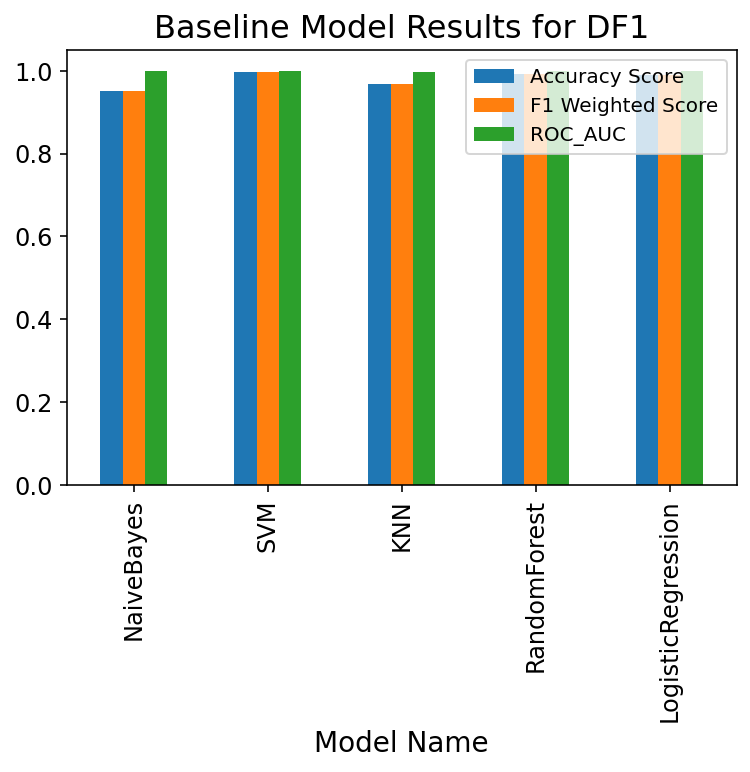

In [ ]:
# Plotting a bar chart for Accuracy, F1 weighted score and AUC_ROC for all the models trained above on dataset 1
baselineResultsDf = pd.DataFrame(baselineResultsDF1, columns=['Model Name', 'Accuracy Score', 'F1 Weighted Score', 'ROC_AUC'])
baselineResultsDf.plot.bar('Model Name',['Accuracy Score','F1 Weighted Score','ROC_AUC'], title='Baseline Model Results for DF1')

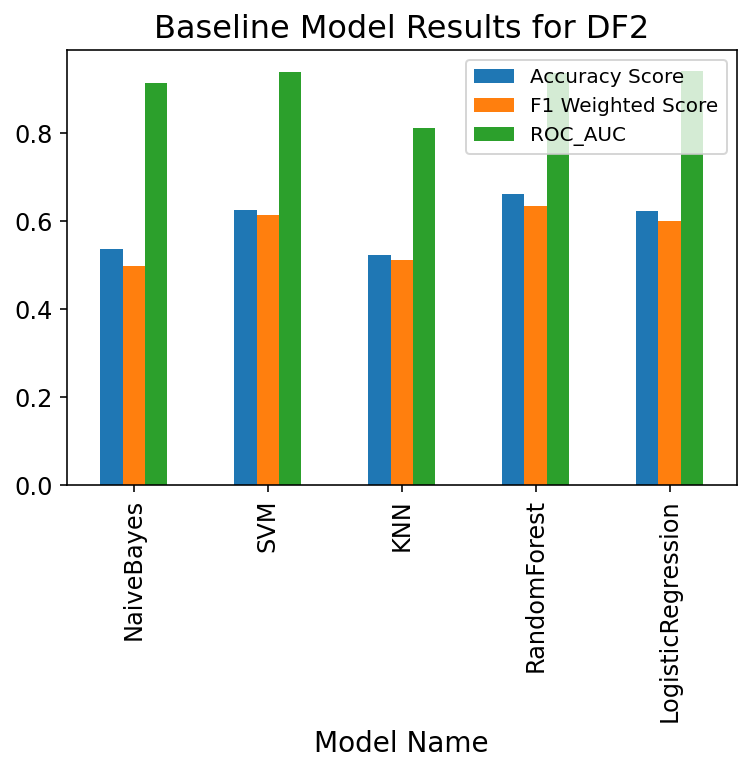

In [ ]:
# Plotting a bar chart for Accuracy, F1 weighted score and AUC_ROC for all the models trained above on dataset 2

baselineResultsDf2 = pd.DataFrame(baselineResultsDF2, columns=['Model Name', 'Accuracy Score', 'F1 Weighted Score', 'ROC_AUC'])
baselineResultsDf2.plot.bar('Model Name',['Accuracy Score','F1 Weighted Score','ROC_AUC'], title='Baseline Model Results for DF2')

In [ ]:
#Summarising the results on dataset 1
print('Tabulation of Baseline Model Traning Results:\n ')
print('For first Dataset: ')
baselineResultsDf

Tabulation of Baseline Model Traning Results:
 
For first Dataset: 


,Model Name,Accuracy Score,F1 Weighted Score,ROC_AUC
0,NaiveBayes,0.951557,0.950036,0.999921
1,SVM,0.996540,0.996589,1.000000
2,KNN,0.968858,0.967896,0.997558
3,RandomForest,0.993080,0.993067,1.000000
4,LogisticRegression,0.989619,0.989528,0.999982


In [ ]:
#Summarising the results on dataset2
print('For second Dataset: ')
baselineResultsDf2

For second Dataset: 


,Model Name,Accuracy Score,F1 Weighted Score,ROC_AUC
0,NaiveBayes,0.536193,0.497619,0.912213
1,SVM,0.624665,0.612530,0.939157
2,KNN,0.521448,0.512165,0.811815
3,RandomForest,0.660858,0.634825,0.936304
4,LogisticRegression,0.623324,0.599786,0.940849


**Model Peformance after Hyperparamater Tuning**

In [ ]:
#Summarizing the results for the hyperparameterised model's on dataset1
print('Tabulation of Hyperparameter Tuning Results for first Dataset:\n ')
tuningResultsDf1 = pd.DataFrame(tuningResultsDF1, columns=['Model Name', 'Best Parameters', 'Accuracy Score', 'F1 Weighted Score'])
tuningResultsDf1

Tabulation of Hyperparameter Tuning Results for first Dataset:
 


,Model Name,Best Parameters,Accuracy Score,F1 Weighted Score
0,RandomForest,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.975779,0.970439
1,SVM,"{'C': 1, 'break_ties': False, 'cache_size': 20...",0.996540,0.996589
2,KNN,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.993080,0.993067
3,LogisticRegression,"{'C': 0.0, 'class_weight': None, 'dual': False...",0.993080,0.993067


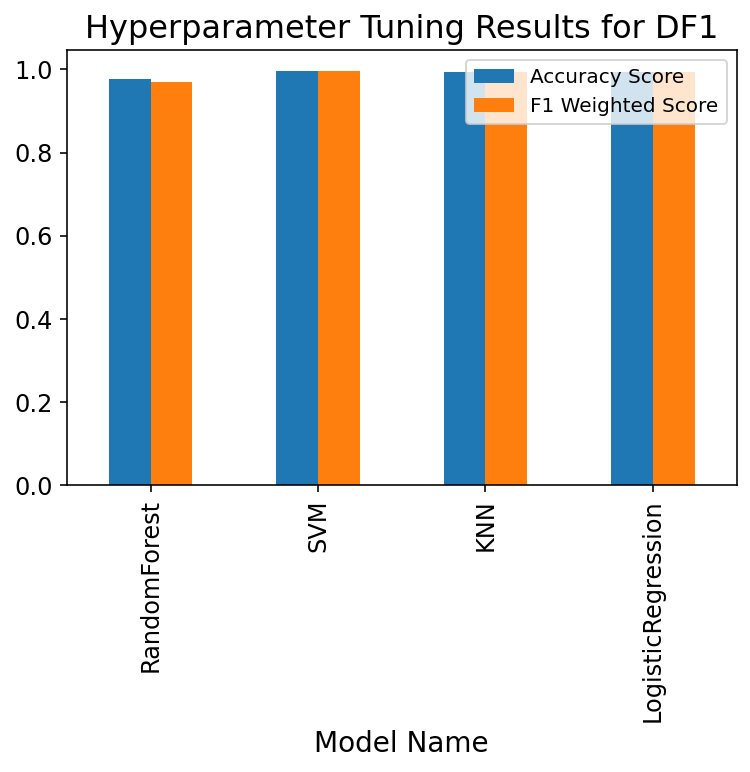

In [ ]:
#Plotting a bar plot for the hyperparameterised models on dataset1
tuningResultsDf1.plot.bar('Model Name',['Accuracy Score','F1 Weighted Score'], title='Hyperparameter Tuning Results for DF1')

In [ ]:
#Summarising the results of the hyperparameterised models on dataset2

print('Tabulation of Hyperparameter Tuning Results for second Dataset:\n ')
tuningResultsDf2 = pd.DataFrame(tuningResultsDF2, columns=['Model Name', 'Best Parameters', 'Accuracy Score', 'F1 Weighted Score'])
tuningResultsDf2

Tabulation of Hyperparameter Tuning Results for second Dataset:
 


,Model Name,Best Parameters,Accuracy Score,F1 Weighted Score
0,RandomForest,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.638070,0.590421
1,SVM,"{'C': 10, 'break_ties': False, 'cache_size': 2...",0.648794,0.642815
2,KNN,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.546917,0.524033
3,LogisticRegression,"{'C': 0.0, 'class_weight': None, 'dual': False...",0.667560,0.663634


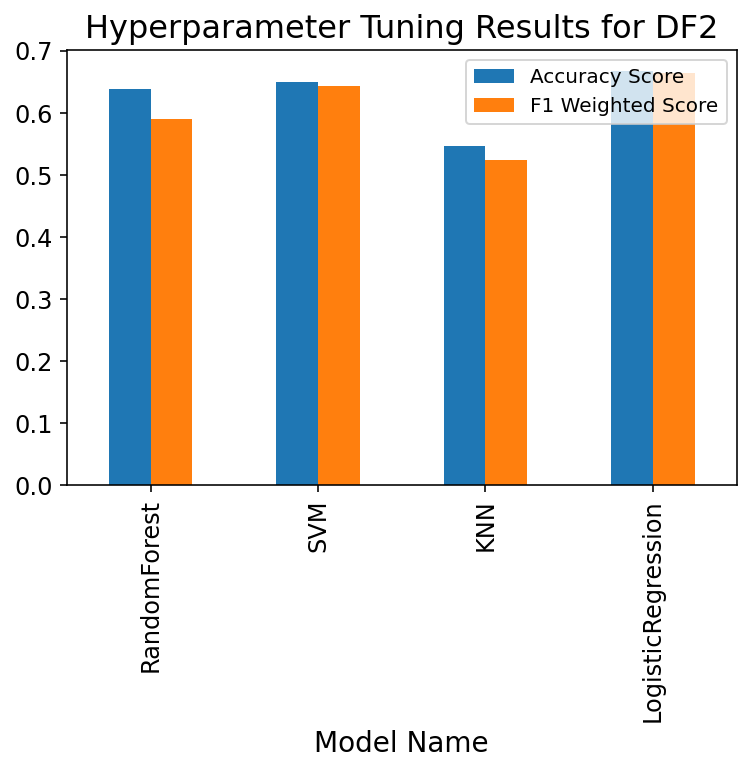

In [ ]:

tuningResultsDf2.plot.bar('Model Name',['Accuracy Score','F1 Weighted Score'], title='Hyperparameter Tuning Results for DF2')

**Observations**

**Classification Results**

From the results above, we can see that SVM performed the best on the first dataset and LogisticRegression performed the best on the second dataset. 


Although no one algorithm really outperformed in either of the cases, indicating the results are more dependent on the data and preprocessing rather than the choice of algorithm.

We make this conclusion based on two facts:

1.   Overall Accuracy: Of all the models tested, SVM and LogisticRegression provided the best overall accuracy on the training set in df1 and df2 respectively. Which means they gives accurate predictions in general.
2.   F1 Weighted Score: A high F1 weighted score, which means they have better precision and recall across all the classes when compared to the other models. 


**Difference in accuracies between Dataset 1 and Dataset 2**

Dataset1 has much better accuracy than Dataset2, even though Dataset 1 has seemingly closer looking labels. This may seem counterintuitive but can be explained by looking at the datasets and the analysis done above.

The resumes in Dataset1, which contains a lot of Computer Science related labels, have very distinct keywords in the form of software, languages, frameworks, etc which sets the classes apart.

On the other hand dataset2, which has different industries as labels, has a lot of keywords which are common across industries which makes it harder to classify a resume. 

From this we can also infer that it is easier to predict a very specific job role, but harder to predict the general industry where a candidates resume fits in as most skills are interoperable across domains.